<a href="https://colab.research.google.com/github/PeterSlakhorst/colab_jupyter/blob/master/ols.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pandas_datareader import data
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score


/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
def load_financial_data(start_date, end_date, output_file):
    try:
        df = pd.read_pickle(output_file)
        print('File data found...reading GOOG data')
    except FileNotFoundError:
        print('File not found...downloading the GOOG data')
        df = data.DataReader('GOOG', 'yahoo', start_date, end_date)
        df.to_pickle(output_file)
    return df

def create_classification_trading_condition(df):
    df['Open-Close'] = df.Open - df.Close
    df['High-Low'] = df.High - df.Low
    df = df.dropna()
    X = df[['Open-Close', 'High-Low']]
    Y = np.where(df['Close'].shift(-1) > df['Close'], 1, -1)
    return (df, X, Y)

def create_regression_trading_condition(df):
    df['Open-Close'] = df.Open - df.Close
    df['High-Low'] = df.High - df.Low
    df['Target'] = df['Close'].shift(-1) - df['Close']
    df = df.dropna()
    X = df[['Open-Close', 'High-Low']]
    Y = df[['Target']]
    return (df, X, Y)

def create_train_split_group(X, Y, split_ratio=0.8):
    return train_test_split(X, Y, shuffle=False, train_size=split_ratio)

def calculate_return(df, split_value, symbol):
    cum_goog_return = df[split_value:]['%s_Returns' % symbol].cumsum() * 100
    df['Strategy_Returns'] = df['%s_Returns' %
                                symbol] * df['Predicted_Signal'].shift(1)
    return cum_goog_return


def calculate_strategy_return(df, split_value, symbol):
    cum_strategy_return = df[split_value:]['Strategy_Returns'].cumsum() * 100
    return cum_strategy_return

In [3]:
def plot_shart(cum_symbol_return, cum_strategy_return, symbol):
    plt.figure(figsize=(10, 5))
    plt.plot(cum_symbol_return, label='%s Returns' % symbol)
    plt.plot(cum_strategy_return, label='Strategy Returns')
    plt.legend()
    plt.show()
    

def sharpe_ratio(symbol_returns, strategy_returns):
    strategy_std = strategy_returns.std()
    sharpe = (strategy_returns - symbol_returns) / strategy_std
    return sharpe.mean()


File not found...downloading the GOOG data
Coefficients: 
 [[ 0.02410177 -0.05781461]]
                 High        Low  ...  Predicted_Signal  GOOG_Returns
Date                              ...                                
2004-08-19  51.835709  47.800831  ...          0.281273           NaN
2004-08-20  54.336334  50.062355  ...          0.183888      0.076433
2004-08-23  56.528118  54.321388  ...          0.407256      0.010013
2004-08-24  55.591629  51.591621  ...          0.363848     -0.042289
2004-08-25  53.798351  51.746044  ...          0.387490      0.010718

[5 rows x 11 columns]


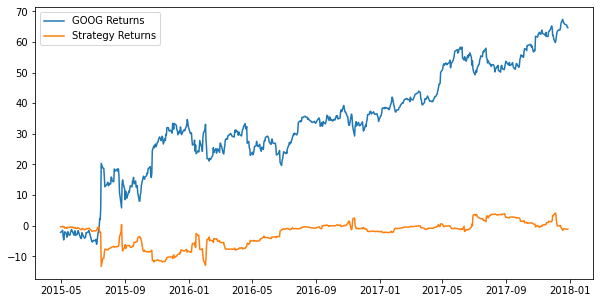

2.0840606780226065
Mean squared error: 27.52
Variance score: 0.00
Mean squared error: 103.50
Variance score: -0.01


In [4]:
goog_data = load_financial_data(
    start_date='2001-01-01',
    end_date='2018-01-01',
    output_file='goog_data_large.pkl')

goog_data, X, Y = create_regression_trading_condition(goog_data)

X_train,X_test,Y_train,Y_test=create_train_split_group(X,Y,split_ratio=0.8)


# Fit the model
ols = linear_model.LinearRegression()
ols.fit(X_train, Y_train)
# Forecast value

# The coefficients
print('Coefficients: \n', ols.coef_)

goog_data['Predicted_Signal'] = ols.predict(X)
goog_data['GOOG_Returns'] = np.log(
    goog_data['Close'] / goog_data['Close'].shift(1))

print(goog_data.head())


cum_goog_return = calculate_return(
    goog_data, split_value=len(X_train), symbol='GOOG')
cum_strategy_return = calculate_strategy_return(
    goog_data, split_value=len(X_train), symbol='GOOG')

plot_shart(cum_goog_return, cum_strategy_return, symbol='GOOG')

print(sharpe_ratio(cum_strategy_return, cum_goog_return))


# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(Y_train, ols.predict(X_train)))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(Y_train, ols.predict(X_train)))

# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(Y_test, ols.predict(X_test)))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(Y_test, ols.predict(X_test)))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7c882b81d0>,
      dtype=object)

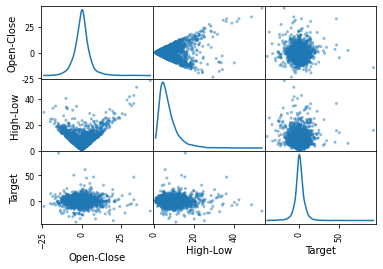

In [5]:
pd.plotting.scatter_matrix(goog_data[['Open-Close', 'High-Low',
'Target']], grid=True, diagonal='kde')